# Menggunakan Pretrained Model untuk Segmentasi Bangunan dengan Deep Learning

Notebook berikut membahas secara singkat mengenai bagaimana model yang dibangun dengan menggunakan Deep Learning dapat digunakan untuk melakukan segmentasi pada data foto udara atau citra satelit. Alih-alih melakukan training dari awal, pada notebook ini akan diberikan contoh bagaimana menggunakan pre-trained model (model deep learning yang telah dilatih sebelumnya) untuk melakukan prediksi dalam bentuk segmentasi foto udara. 

Pre-trained model dan script pada notebook ini dibuat menggunakan kumpulan script yang terdapat pada https://github.com/fuzailpalnak/building-footprint-segmentation. Pada notebook ini akan dijelaskan juga sedikit mengenai konsep *transfer learning* dan bagaimana menggunakannya untuk segmentasi. Konsep yang lebih dalam mengenai *transfer learning* dan bagaimana membangun model baru dengannya akan dijelaskan pada notebook lain --Insya Allah 😉.


![](https://media.giphy.com/media/CjmvTCZf2U3p09Cn0h/giphy.gif)

## Background

Terdapat beberapa cara untuk melakukan segmentasi pada data citra satelit menggunakan Deep Learning. Di notebook ini kita akan menggunakan cara yang paling mudah: menggunakan model yang telah di'training' atau dilatih oleh orang lain pada set data yang mirip, kemudian menerapkannya untuk melakukan segmentasi. Script yang akan kita gunakan dapat ditemukan di sini: https://github.com/fuzailpalnak/building-footprint-segmentation

## Instalasi Libraries dan Persiapan

Pada bagian ini, kita lakukan beberapa persiapan, seperti instalasi library dan pengaturan parameter.

Pertama, kita lakukan terlebih dahulu instalasi library yang akan kita gunakan:

In [ ]:
# https://github.com/fuzailpalnak/building-footprint-segmentation/
!pip install building-footprint-segmentation --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Kita panggil beberapa library yang akan digunakan nantinya:

In [ ]:
import os.path
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave
#from imageio import imsave
from torch.utils import model_zoo


Cell di bawah ini memanggil fungsi dan method yang telah dibuat sebelumnya pada script dari https://github.com/fuzailpalnak/building-footprint-segmentation/

In [ ]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

# from building_footprint_segmentation.segmentation import init_segmentation, read_trainer_config
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model,
)
from building_footprint_segmentation.utils.operations import handle_image_size

Selanjutnya adalah melakukan beberapa pengaturan parameter mendasar untuk melakukan prediksi:

* `MAX_SIZE` 

Ukuran maksimal citra yang akan diolah. Karena library ini menggunakan model deep learning dalam bentuk tensor, angka ini harus merupakan kelipatan dari 32. 
Idealnya, angka ini sesuai dengan dimensi dari citra yang akan diprediksi (jumlah terbesar dari total piksel baris dan kolom), akan tetapi keterbatasan komputasi membuat kita hanya dapat melakukan prediksi pada citra dengan ukuran tertentu.

Konsekuensinya adalah hasil segmentasi yang kita peroleh nantinya akan terpotong sesuai ukuran masukan ini.

* `TRAINED_MODEL`

Terdapat dua jenis pre-trained model yang disediakan oleh library yang kita gunakan, yaitu **ReFineNet** dan **DlinkNet**. ReFineNet dilatih terhadap data [Manchester Buildings Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset) yang disediakan pada Kaggle. Penjelasan lengkap untuk ReFineNet ada pada [link berikut](https://github.com/fuzailpalnak/building-footprint-segmentation/issues/42#issuecomment-1238156123)

In [ ]:
# Kelipatan 32. 
# Seharusnya sesuai dengan ukuran citra, tetapi memory yang disediakan colab tidak memadai
MAX_SIZE = 3040

# Menggunakan model RefineNet
TRAINED_MODEL = ReFineNet()
MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"

Setelah mendefinisikan parameter-parameter di atas, selanjutnya kita buat beberapa fungsi untuk memudahkan prediksi nantinya.

## Definisi Fungsi Segmentasi

Pada bagian ini, kita definisikan tiga buah fungsi:

In [ ]:
def get_model():
    model = TRAINED_MODEL
    state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    if "model" in state_dict:
      state_dict = state_dict["model"]
    model.load_state_dict(adjust_model(state_dict))
    return model

In [ ]:
def extract(original_image):
    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        prediction = TRAINED_MODEL(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )
    return prediction_binary, prediction_3_channels, dst

In [ ]:
def run(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # set_model_weights()
    model = get_model()
    # ada bug di script sehingga parallel processing tidak dapat dilakukan
    # model = load_parallel_model(model)
    

    prediction_binary, prediction_3_channels, dst = extract(original_image)
    # imsave(f"{os.path.basename(image_path)}", prediction_binary)
    imsave("Hasil", prediction_binary)
    return prediction_binary, prediction_3_channels, dst

## Jalankan Prediksi dengan Pre-trained Model

Sebelum menjalankan fungsi-fungsi di atas untuk melakukan prediksi, terlebih dahulu kita perlu untuk menambahkan data yang akan diprediksi (atau di-segmentasi). Data ini adalah citra kampus Fakultas Teknik UGM. Tambahkan data ini pada Google Drive masing-masing, kemudian kita muat pada notebook ini menggunakan ```google.colab```.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Periksa _path_ dari citra yang tersimpan di Google Drive dan sesuaikan dengan link di bawah ini:

In [ ]:
path_citra = "/content/gdrive/MyDrive/Akademik Geodesi/Tutor/Deep Learning/FT_7 Sept 2022 Med Res.tif"

Setelah semua siap, saatnya melakukan prediksi!

In [ ]:
%%time
pred = run(path_citra)

## Tampilkan Hasil Prediksi

Hasil prediksi berupa Numpy array yang berisi tiga buah citra segmentasi. Nilai segmentasi pada tiap piksel pada dasarnya diperoleh dari nilai probabilitas segmentasi sesuai dengan training yang dilakukan di atas. Kita gunakan matplotlib untuk menampilkan hasil prediksi tersebut:

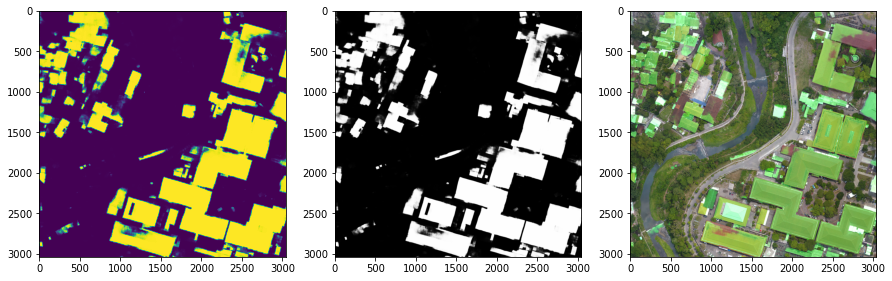

In [ ]:
fig,ax = plt.subplots(1,3,figsize = (15,15))
ax = ax.ravel()
for i in range(3):
  image = pred[i]
  ax[i].imshow(image)  
plt.show()

Agar tampilan lebih besar, ubah seperti berikut:

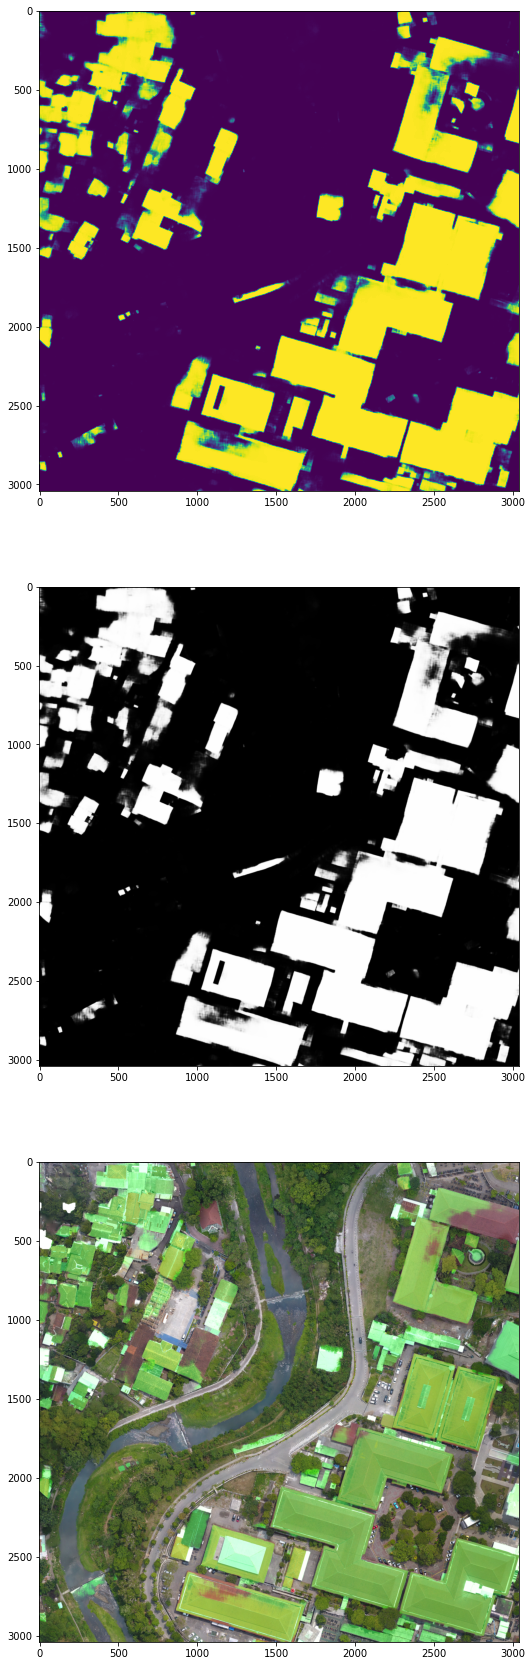

In [ ]:
fig,ax = plt.subplots(3,1,figsize = (30,30))
ax = ax.ravel()
for i in range(3):
  image = pred[i]
  ax[i].imshow(image)  
plt.show()

Pada salah satu script function di atas terdapat sebuah perintah untuk menyimpan hasil prediksi. Rubah parameter tersebut untuk meng-eksport hasil training menjadi file dengan ekstensi *.tiff

## Apa Selanjutnya?

Setelah memahami bagaimana sebuah model deep learning dapat digunakan untuk memprediksi sebuah segmentasi, berikut adalah beberapa point yang dapat digunakan sebagai panduan langkah selanjutnya:

* Untuk data berukuran besar, terlebih dahulu pecah data tersebut menjadi gambar berukuran lebih kecil, kemudian lakukan inference/prediksi pada data tersebut satu-persatu, baru kemudian gabungkan keseluruhan data tersebut menjadi sebuah citra yang utuh
* Lakukan transfer learning pada model tersebut dengan menggunakan data training dan validasi yang lain, misalnya dengan menggunakan set data INRIA atau AIRS
* Lakukan fine-tuning: rubah parameter-parameter learning seperti learning rate, batch size dan lain sebagainya sehingga diperoleh hasil yang paling memuaskan
* Pre-processing dan post-processing data geospasial, misalnya, lakukan _augmentasi_ pada data training untuk mencoba berbagai skenario pada model



## Rujukan-rujukan

* https://towardsdatascience.com/semantic-segmentation-of-aerial-imagery-captured-by-a-drone-using-different-u-net-approaches-91e32c92803c

* https://walkwithfastai.com/Segmentation

* https://towardsdatascience.com/learn-ai-today-05-image-segmentation-with-u-net-models-800105e400d1